# Alzheimer Classification Using CNN & ResNet50

## Objective : 
- This project focuses on image classification for Alzheimer’s disease detection using a Convolutional Neural Network (CNN) model based on ResNet50. After training the model, Explainable Artificial Intelligence (XAI) techniques, such as LIME and Grad-CAM, are applied to explain and interpret the model's predictions.



In [27]:
import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from PIL import Image
from skimage.segmentation import slic

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Recall
from sklearn.metrics import classification_report,accuracy_score

warnings.filterwarnings("ignore")


# ------------------------------------------------------------------
# **Step 1: Creating the DataFrame with paths and labels**
# ------------------------------------------------------------------

In [6]:
data_dir = r'DataSet/AugmentedAlzheimerDataset/'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data_df = pd.concat([Fseries, Lseries], axis= 1)
data_df

,filepaths,labels
0,DataSet/AugmentedAlzheimerDataset/MildDemented...,MildDemented
1,DataSet/AugmentedAlzheimerDataset/MildDemented...,MildDemented
2,DataSet/AugmentedAlzheimerDataset/MildDemented...,MildDemented
3,DataSet/AugmentedAlzheimerDataset/MildDemented...,MildDemented
4,DataSet/AugmentedAlzheimerDataset/MildDemented...,MildDemented
...,...,...
33979,DataSet/AugmentedAlzheimerDataset/VeryMildDeme...,VeryMildDemented
33980,DataSet/AugmentedAlzheimerDataset/VeryMildDeme...,VeryMildDemented
33981,DataSet/AugmentedAlzheimerDataset/VeryMildDeme...,VeryMildDemented
33982,DataSet/AugmentedAlzheimerDataset/VeryMildDeme...,VeryMildDemented


In [7]:
data_df.to_csv('data_df.csv', index=False)

# ----------------------------------------------
# **Analysis of Label Distribution**
# ----------------------------------------------

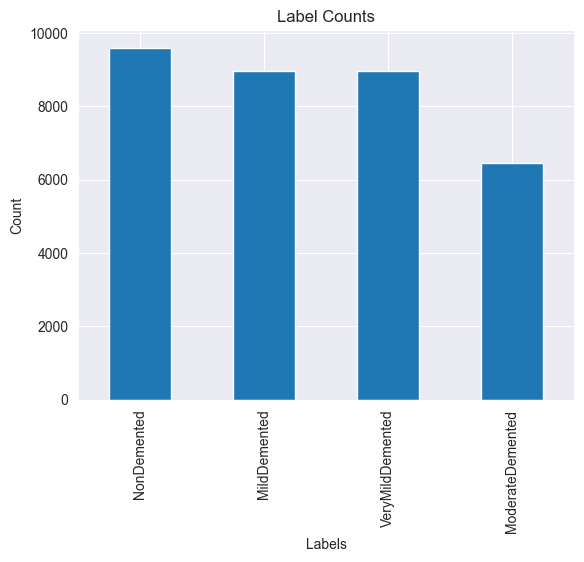

In [8]:
label_counts = data_df['labels'].value_counts()
label_counts_df = pd.DataFrame(label_counts)

# Plot the bar chart
label_counts_df.plot(kind='bar', legend=False)
plt.title('Label Counts')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# ----------------------------------------------------
# **Step 2: Preparing Training and Test Data**
# ----------------------------------------------------

In [9]:
test_df,train_df = train_test_split(data_df,  train_size= 0.2, shuffle= True, random_state= 42)
print(test_df.shape)
print(train_df.shape)

(6796, 2)
(27188, 2)


# ---------------------------------------------------------------------------------------------
# **Step 3: Image Data Generators & Configuration  Setup for Training and Testing**
# --------------------------------------------------------------------------------------------

In [10]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df,rescale=1./255, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

Found 27188 validated image filenames belonging to 4 classes.


In [11]:
test_gen = ts_gen.flow_from_dataframe( test_df,rescale=1./255, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 6796 validated image filenames belonging to 4 classes.


# --------------------------------------------------------------------------------
# **Step 3: Extracting Batches from Training and Testing Generators**
# -------------------------------------------------------------------------------

In [14]:
x_train, y_train = next(train_gen)
x_test, y_test = next(test_gen)

# --------------------------------------------------------------------------------
# **Visualizing Sample Images with Class Labels from Training Data**
# --------------------------------------------------------------------------------

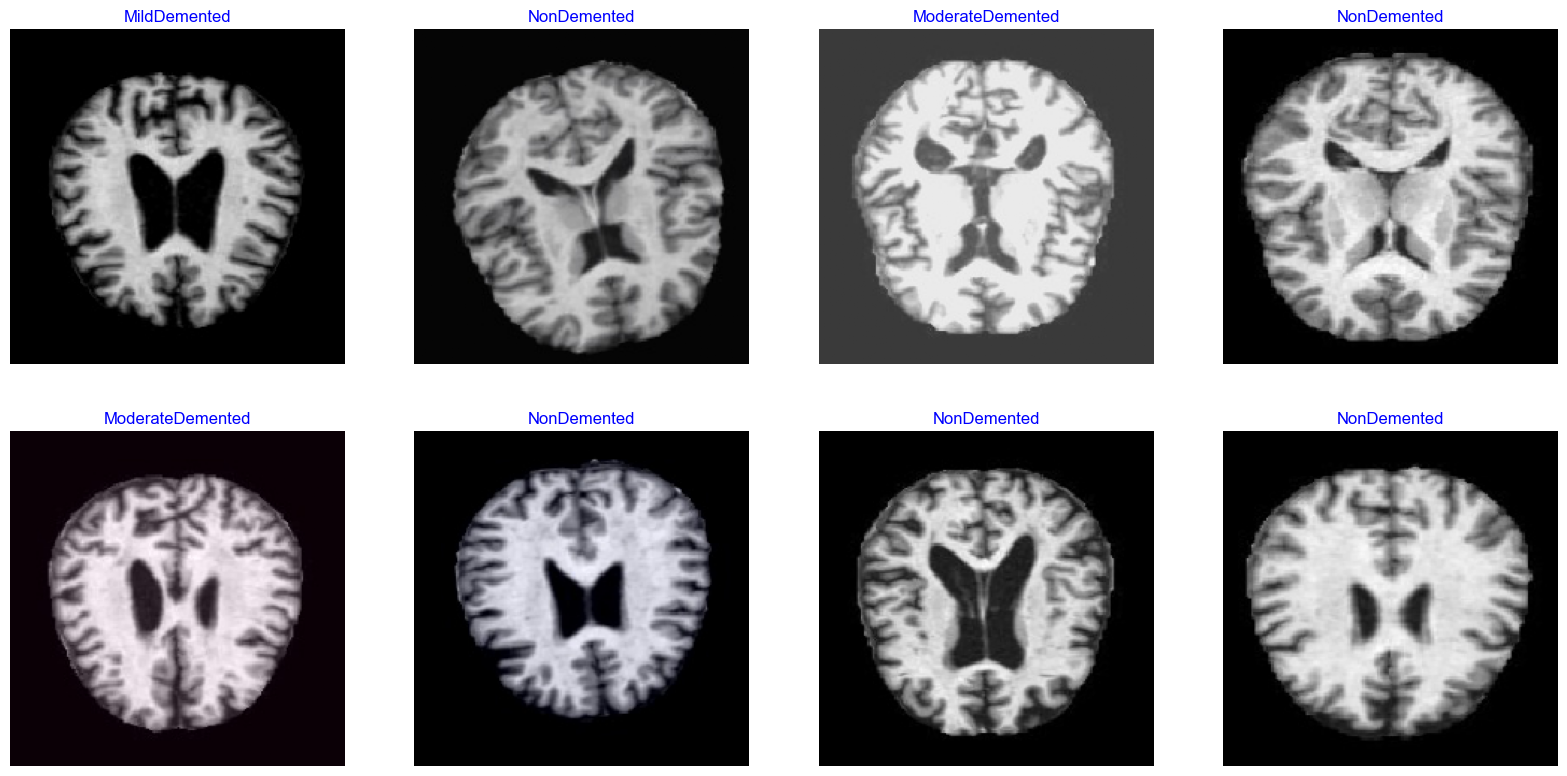

In [15]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(8):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# --------------------------------------------------------------------------------
# **Step 4: Building and Training a Transfer Learning Model Using ResNet50**
# --------------------------------------------------------------------------------

In [17]:

with tf.device('/GPU:0'):    
    feature_names = train_gen.classes
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(4, activation='softmax')(x)
    
    model = models.Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers[-10:]:
        layer.trainable = True
    
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    
    history=model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // batch_size,
        epochs=10,
        validation_data=test_gen,
        validation_steps=test_gen.samples // batch_size
    )

Epoch 1/10
1699/1699 [==============================] - 233s 131ms/step - loss: 0.6793 - accuracy: 0.6998 - val_loss: 0.4218 - val_accuracy: 0.8237
Epoch 2/10
1699/1699 [==============================] - 222s 131ms/step - loss: 0.3542 - accuracy: 0.8582 - val_loss: 0.3680 - val_accuracy: 0.8554
Epoch 3/10
1699/1699 [==============================] - 223s 131ms/step - loss: 0.1979 - accuracy: 0.9250 - val_loss: 0.3079 - val_accuracy: 0.8908
Epoch 4/10
1699/1699 [==============================] - 223s 131ms/step - loss: 0.1273 - accuracy: 0.9534 - val_loss: 0.2036 - val_accuracy: 0.9205
Epoch 5/10
1699/1699 [==============================] - 224s 132ms/step - loss: 0.0974 - accuracy: 0.9650 - val_loss: 0.2711 - val_accuracy: 0.9076
Epoch 6/10
1699/1699 [==============================] - 224s 132ms/step - loss: 0.0722 - accuracy: 0.9751 - val_loss: 0.2421 - val_accuracy: 0.9217
Epoch 7/10
1699/1699 [==============================] - 226s 133ms/step - loss: 0.0622 - accuracy: 0.9788 - val_

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# --------------------------------------------------------------------------------
# **Training and Validation Accuracy Over Epochs and save Model"**
# --------------------------------------------------------------------------------

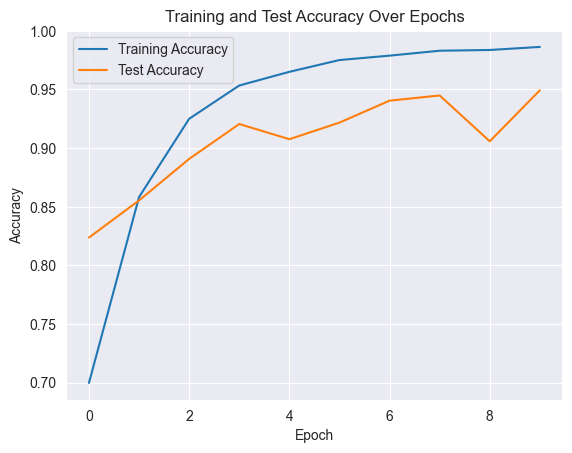

In [32]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.savefig("Training and Test Accuracy.png")
plt.show()

In [24]:
model.save('model_xai_21.h5')

# --------------------------------------------------------------------------------
# **Step 5: Evaluating Model Performance: Recall and Accuracy Calculation**
# --------------------------------------------------------------------------------

In [25]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [28]:
y_true = tf.convert_to_tensor(test_gen.classes)
y_pred = tf.convert_to_tensor(y_pred)

# Create a Recall metric instance
recall_metric = Recall()

# Update the metric with your data
recall_metric.update_state(y_true, y_pred)

# Get the computed recall
recall_result = recall_metric.result().numpy()

print("Recall:", recall_result)
accuracy=accuracy_score(test_gen.classes, y_pred)
print("Accuracy: ",accuracy)

Recall: 0.99247974
Accuracy:  0.9493819894055326


# --------------------------------------------------------------------------------
# **Step 6: Visualizing the Confusion Matrix for Model Predictions**
# --------------------------------------------------------------------------------

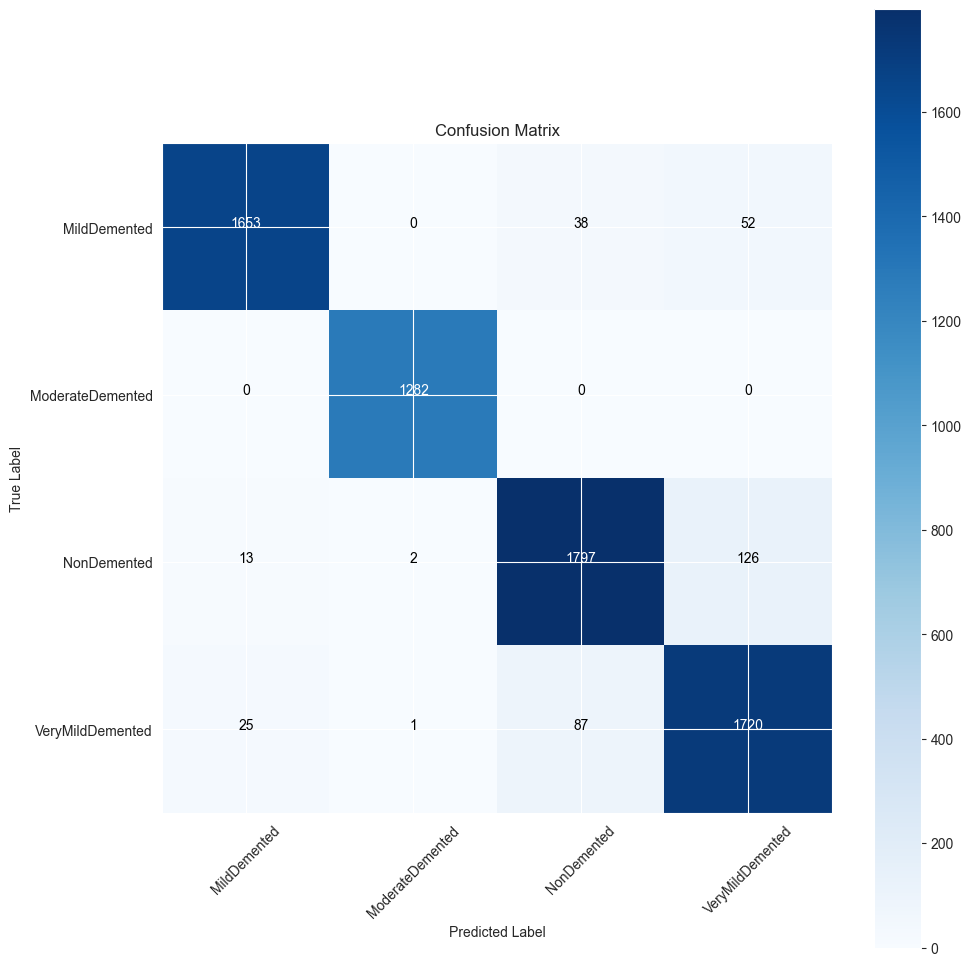

In [29]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrixRenet50.png')
plt.show()

# --------------------------------------------------------------------------------
# **Step : Generating a Classification Report for Model Evaluation**
# --------------------------------------------------------------------------------

In [30]:
print(classification_report(test_gen.classes, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1743
           1       1.00      1.00      1.00      1282
           2       0.93      0.93      0.93      1938
           3       0.91      0.94      0.92      1833

    accuracy                           0.95      6796
   macro avg       0.95      0.95      0.95      6796
weighted avg       0.95      0.95      0.95      6796

